In [1]:
import numpy as np
import time
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from june import World 
from june.geography import Geography
from june.demography import Demography
from june.interaction import Interaction
from june.infection import Infection, InfectionSelector
from june.infection.health_index import Data2Rates
from june.infection.health_index.health_index import HealthIndexGenerator
from june.infection.transmission import TransmissionConstant
from june.groups import Hospitals, Schools, Companies, Households, CareHomes, Cemeteries, Universities
from june.groups.leisure import generate_leisure_for_config, Cinemas, Pubs, Groceries
from june.groups.travel import *
from june.simulator import Simulator
from june.infection_seed import InfectionSeed
from june.policy import Policy, Policies
from june import paths
from june.hdf5_savers import load_geography_from_hdf5
from june.records import Record, RecordReader

from june.world import generate_world_from_geography
from june.hdf5_savers import generate_world_from_hdf5

No --data argument given - defaulting to:
/home/arnau/code/JUNE/data
No --configs argument given - defaulting to:
/home/arnau/code/JUNE/june/configs
INFO:numexpr.utils:NumExpr defaulting to 4 threads.


# Initialize world

To initialize a certain world, we need to add the different components we want to have in it. First we specify what super areas (msoa) we want to create. We have included these ones, because they are known to contain hospitals, schools, care homes, and companies.

After creating the geography, we create the different components the worlds need to have such as care homes, companies ...

In [3]:
CONFIG_PATH = paths.configs_path / "config_example.yaml"

In [4]:
%%time 

geography = Geography.from_file(
{
    "super_area": ["E02001731", "E02002566"]})

geography.hospitals = Hospitals.for_geography(geography)
geography.schools = Schools.for_geography(geography)
geography.companies = Companies.for_geography(geography)
geography.care_homes = CareHomes.for_geography(geography)
geography.universities = Universities.for_geography(geography)
world = generate_world_from_geography(geography, include_households=True)


2020-12-15 11:06:25,467 - june.geography.geography - INFO - There are 67 areas and 2 super_areas and 1 in the world.
2020-12-15 11:06:25,472 - hospitals - INFO - There are 1 hospitals in this geography.
2020-12-15 11:06:25,528 - schools - INFO - There are 7 schools in this geography.
2020-12-15 11:06:25,539 - schools - INFO - No school for the age 0 in this world.
2020-12-15 11:06:25,542 - schools - INFO - No school for the age 1 in this world.
2020-12-15 11:06:25,567 - schools - INFO - No school for the age 12 in this world.
2020-12-15 11:06:25,570 - schools - INFO - No school for the age 13 in this world.
2020-12-15 11:06:25,897 - care_homes - INFO - There are 4 care_homes in this geography.
2020-12-15 11:06:25,948 - universities - INFO - There are 3 universities in this world.
2020-12-15 11:06:30,271 - world - INFO - Populating areas
2020-12-15 11:06:30,517 - world - INFO - Areas populated. This world's population is: 19199
2020-12-15 11:06:32,481 - worker_distributor - INFO - Distr

## Commute, travel and leisure

In [5]:
%%time

world.pubs = Pubs.for_geography(geography)
world.cinemas = Cinemas.for_geography(geography)
world.groceries = Groceries.for_geography(geography)
leisure = generate_leisure_for_config(world, config_filename=CONFIG_PATH)
leisure.distribute_social_venues_to_areas(
    areas=world.areas, super_areas=world.super_areas
)


2020-12-15 11:06:37,143 - social_venue - INFO - Domain 0 has 2963 pubs(s)
2020-12-15 11:06:37,156 - social_venue - INFO - Domain 0 has 14 cinemas(s)
2020-12-15 11:06:37,372 - social_venue - INFO - Domain 0 has 834 groceries(s)
2020-12-15 11:06:37,390 - leisure - INFO - Linking households for visits
2020-12-15 11:06:37,558 - leisure - INFO - Done
2020-12-15 11:06:37,559 - leisure - INFO - Linking households with care homes for visits
2020-12-15 11:06:37,603 - leisure - INFO - Done
2020-12-15 11:06:37,604 - leisure - INFO - Distributing social venues to areas
2020-12-15 11:06:37,604 - leisure - INFO - Distributed in 0 of 67 areas.
2020-12-15 11:06:37,682 - leisure - INFO - Distributed in 67 of 67 areas.
CPU times: user 1.34 s, sys: 6.86 ms, total: 1.35 s
Wall time: 1.35 s


In [6]:
# initialise commuting travel
travel = Travel()
travel.initialise_commute(world)

2020-12-15 11:06:37,691 - travel - INFO - Initialising commute...
2020-12-15 11:06:37,692 - travel - INFO - Creating cities...
2020-12-15 11:06:37,700 - travel - INFO - This world has 2 cities, with names
['Newcastle upon Tyne', 'Darlington']
2020-12-15 11:06:37,700 - travel - INFO - Determining people mode of transport
2020-12-15 11:06:43,632 - travel - INFO - Mode of transport allocated in 0 of 67 areas.
2020-12-15 11:06:43,651 - travel - INFO - Mode of transport determined for everyone.
2020-12-15 11:06:43,778 - travel - INFO - Assigning commuters to stations...
2020-12-15 11:06:43,779 - travel - INFO - Assigned 0 of 19199 potential commuters...
2020-12-15 11:06:43,784 - travel - INFO - Commuters assigned
2020-12-15 11:06:43,784 - travel - INFO - City Newcastle upon Tyne has 920 internal and 186 external commuters.
2020-12-15 11:06:43,787 - travel - INFO - Creating stations...
2020-12-15 11:06:43,790 - travel - INFO - City Newcastle upon Tyne has 1 city and 4 inter city stations.
20

We are also going to need some cemeteries...


In [7]:
world.cemeteries = Cemeteries()

### If it took a long time to run the previous commands, it might be a good idea to save the world to reuse it later.

In [8]:
world.to_hdf5("world.hdf5")

2020-12-15 11:06:43,813 - world_saver - INFO - saving world to HDF5
2020-12-15 11:06:43,827 - world_saver - INFO - saving population...
2020-12-15 11:06:44,264 - world_saver - INFO - saving hospitals...
2020-12-15 11:06:44,267 - world_saver - INFO - saving schools...
2020-12-15 11:06:44,273 - world_saver - INFO - saving companies...
2020-12-15 11:06:44,287 - world_saver - INFO - saving households...
2020-12-15 11:06:44,419 - world_saver - INFO - saving care homes...
2020-12-15 11:06:44,421 - world_saver - INFO - saving cities...
2020-12-15 11:06:44,425 - world_saver - INFO - saving stations...
2020-12-15 11:06:44,429 - world_saver - INFO - saving universities...
2020-12-15 11:06:44,432 - world_saver - INFO - saving social venues...


If we would like to load the world we saved, we just do

In [9]:
world = generate_world_from_hdf5("world.hdf5")

2020-12-15 11:06:44,446 - world_saver - INFO - loading world from HDF5
2020-12-15 11:06:44,454 - world_saver - INFO - loading hospitals...
2020-12-15 11:06:44,459 - world_saver - INFO - loading schools...
2020-12-15 11:06:44,466 - company_saver - INFO - loading companies...
2020-12-15 11:06:44,467 - company_saver - INFO - Companies chunk 0 of 1
2020-12-15 11:06:44,493 - world_saver - INFO - loading care homes...
2020-12-15 11:06:44,496 - world_saver - INFO - loading universities...
2020-12-15 11:06:44,500 - world_saver - INFO - loading cities...
2020-12-15 11:06:44,503 - world_saver - INFO - loading stations...
2020-12-15 11:06:44,507 - household_saver - INFO - loading households...
2020-12-15 11:06:44,508 - household_saver - INFO - Loaded chunk 0 of 1
2020-12-15 11:06:44,699 - population saver - INFO - loading population...
2020-12-15 11:06:44,700 - population saver - INFO - Loaded chunk 0 of 1
2020-12-15 11:06:44,816 - world_saver - INFO - loading social venues...
2020-12-15 11:06:44

In [10]:
# and regenerate leisure in case we load it externally
leisure = generate_leisure_for_config(world, CONFIG_PATH)
# create travel as well
travel = Travel()

you have now a beautiful pre-pandemic world. 

# Adding the infection

The module in charge of infecting people is called the ``InfectionSelector``, which gives people a transmission time profile and a symptoms trajectory based on their age and sex (through the health index generator)

In [11]:
selector = InfectionSelector.from_file()

# Adding the interaction

In [12]:
interaction = Interaction.from_file(population=world.people)

Beta are the intensities of the interaction taking place at the different groups

In [13]:
interaction.betas

{'box': 1,
 'pub': 0.42941,
 'grocery': 0.04137,
 'cinema': 0.157461,
 'city_transport': 0.107969,
 'inter_city_transport': 0.383,
 'hospital': 0.1168,
 'care_home': 0.28,
 'company': 0.371,
 'school': 0.07,
 'household': 0.208,
 'household_visits': 0.208,
 'care_visits': 0.208,
 'university': 0.306}

Moreover, this interaction module uses contact matrices, that are different for different groups. These contact matrices shouldnt be modified for now. However they are a combination of conversational contact matrices, and physical contact matrices (see the BBC pandemic paper, from where these matrices are extracted https://www.medrxiv.org/content/10.1101/2020.02.16.20023754v2)

There is a parameter, ``alpha`` ($\alpha$), that combines these two matrices in the following way,


$\beta M \left(1 + (\alpha -1) \right) P$

where $\beta$ is the intensity of the interaction, and $P$ the physical contact matrix. A larger $\alpha$ produces more physical contacts. It is an overall number, non dependent of the particular group.


In [14]:
interaction.alpha_physical

2.0

# Seed the disease

There are two options implemented in the seed at the moment, either you specify the number of cases and these are then homogeneously distributed by population to the different areas, or you use UK data on cases per region. For now use the first case.

In [15]:
infection_seed = InfectionSeed(
    world, selector,
)

In [16]:
n_cases = 50
infection_seed.unleash_virus(
    population=world.people,
    n_cases=n_cases) # play around with the initial number of cases

# Set policies

In [17]:
policies = Policies.from_file()

We can have a look at one of the policies

In [18]:
print(policies.individual_policies[8].__dict__)

{'spec': 'close_companies', 'start_time': datetime.datetime(2020, 3, 20, 0, 0), 'end_time': datetime.datetime(2020, 3, 27, 0, 0), 'policy_type': 'individual', 'policy_subtype': 'skip_activity', 'activities_to_remove': ['primary_activity', 'commute'], 'full_closure': False, 'avoid_work_probability': 0.29, 'furlough_probability': 0.04, 'key_probability': 0.19}


# Run the simulation

The first thing we need is a place where to save our simulation results. For that we can use the record class,
and pass it to the simulator.

In [19]:
record = Record(    
    record_path = 'results',    
    record_static_data=True,
) 

In [20]:
record.static_data(world=world)

The simulator is the main module in charge of running the simulation. It coordinates the ``ActivityManager`` which is responsible of allocating people to the right groups given the current timestep, it updates the health status of the population, and it runs the interaction over the different groups. All of these modules can be modified by policies at any given time.

Since the timer configuration is a bit cumbersome, it is read from the config file at https://github.com/IDAS-Durham/JUNE/blob/master/june/configs/config_example.yaml

In [21]:
simulator = Simulator.from_file(
    world=world,
    infection_selector=selector,
    interaction=interaction, 
    config_filename = CONFIG_PATH,
    leisure = leisure,
    travel = travel,
    record=record,
    policies = policies
)

In [22]:
%%time
simulator.run()

2020-12-15 11:06:45,920 - simulator - INFO - Starting simulation for 30 days at day 2020-03-01 00:00:00, to run for 30 days
2020-12-15 11:06:46,106 - simulator - INFO - ==================== timestep ====================
2020-12-15 11:06:46,269 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.5919947549700737e-06,3.337860107421875e-06 - 2020-03-01 00:00:00
2020-12-15 11:06:46,272 - simulator - INFO - Info for rank 0, Date = 2020-03-01 00:00:00, number of deaths =  0, number of infected = 50
2020-12-15 11:06:46,354 - simulator - INFO - CMS: Infection COMS-v2 for rank 0/1(2) 0.00017968099564313889,0.0001785755157470703 - 2020-03-01 00:00:00
2020-12-15 11:06:46,470 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.36237740601063706, 0.3623783588409424 - 2020-03-01 00:00:00

2020-12-15 11:06:46,471 - simulator - INFO - ==================== timestep ====================
2020-12-15 11:06:46,623 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.649009158834815e-06,3.

In [23]:
!pwd

/home/arnau/code/JUNE/Notebooks


While the simulation runs (and afterwards) we can launch the visualization webpage by running
```python june/visualizer.py path/to/results``` 

# Getting the results

The record saves a lot of information about the simulation, and it can be a bit overwhelming to look at everyting.
In the results folder (if you didn't change the path), we have a few extra contents:


In [24]:
!ls results

checkpoints  config.yaml  june_record.h5  policies.txt	summary.csv


Checkpoints would allow us to resume the simulation later, and the config and policies are there to remember what you used to run the code.
The ``summary.csv`` is useful to have a first glance at results:

In [25]:
summary = pd.read_csv("results/summary.csv", index_col=0)
summary.head()

,region,current_infected,daily_infected,current_recovered,daily_recovered,current_hospitalised,daily_hospitalised,current_intensive_care,daily_intensive_care,current_susceptible,daily_hospital_deaths,daily_deaths
time_stamp,,,,,,,,,,,,
2020-03-01,North East,50,0,0,0,0,0,0,0,19149,0,0
2020-03-01,North East,51,1,0,0,0,0,0,0,19148,0,0
2020-03-01,North East,52,1,0,0,0,0,0,0,19147,0,0
2020-03-01,North East,53,1,0,0,0,0,0,0,19146,0,0
2020-03-02,North East,53,0,0,0,0,0,0,0,19146,0,0


/home/arnau/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='time_stamp'>

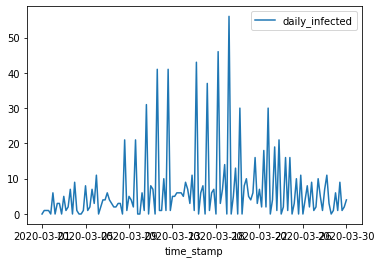

In [26]:
summary.plot(y="daily_infected")

If we want to get the full details, we can read the record:

In [27]:
read = RecordReader("./results")

In [28]:
read.regional_summary.head(3) # this is the equivalent of the summary.csv

,region,current_infected,daily_infected,current_recovered,daily_recovered,current_hospitalised,daily_hospitalised,current_intensive_care,daily_intensive_care,current_susceptible,daily_hospital_deaths,daily_deaths
time_stamp,,,,,,,,,,,,
2020-03-01,North East,51.5,3,0.0,0,0.0,0,0.0,0,19147.5,0,0
2020-03-02,North East,59.6,12,0.0,0,0.0,0,0.0,0,19139.4,0,0
2020-03-03,North East,71.8,15,0.0,0,0.0,0,0.0,0,19127.2,0,0


# Asking questions to the records

## Useful infections and death tables

In [29]:
infections_df = read.get_table_with_extras('infections',
                                           'infected_ids')

2020-12-15 11:07:34,391 - june.records.records_reader - INFO - Loading infections table
2020-12-15 11:07:34,402 - june.records.records_reader - INFO - Loading population table
2020-12-15 11:07:34,444 - june.records.records_reader - INFO - Merging infection and population tables
2020-12-15 11:07:34,448 - june.records.records_reader - INFO - Loading geography table
2020-12-15 11:07:34,466 - june.records.records_reader - INFO - Mergeing infection and geography tables


In [30]:
infections_df.head(10)

,timestamp,location_ids,infector_ids,location_specs,region_names,age,socioeconomic_index,primary_activity_id,residence_id,area_id,sex,ethnicity,primary_activity_type,residence_type,super_area_id,name_area,region_id,name_super_area,name_region
16989,2020-03-01,8181,16984,household,North East,25,4,0,8181,58,f,D,university,household,0,E00175558,0,E02001731,North East
17035,2020-03-02,6,9788,school,North East,30,4,6,8225,58,f,C,school,household,0,E00175558,0,E02001731,North East
16960,2020-03-07,8181,16989,household,North East,23,4,0,8181,58,m,E,university,household,0,E00175558,0,E02001731,North East
17019,2020-03-12,6,10058,school,North East,28,4,6,8243,58,f,A,school,household,0,E00175558,0,E02001731,North East
16906,2020-03-17,0,1674,university,North East,21,4,0,8278,58,m,A,university,household,0,E00175558,0,E02001731,North East
16938,2020-03-24,8278,16906,household,North East,22,4,0,8278,58,m,C,university,household,0,E00175558,0,E02001731,North East
8021,2020-03-01,3420,8006,household,North East,54,4,0,3420,26,m,A,company,household,0,E00042826,0,E02001731,North East
7851,2020-03-11,2490,8021,pub,North East,25,4,0,3369,26,m,E,university,household,0,E00042826,0,E02001731,North East
7972,2020-03-11,2490,8021,pub,North East,34,4,42,3461,26,m,E,company,household,0,E00042826,0,E02001731,North East
7996,2020-03-12,0,12689,hospital,North East,39,4,0,3441,26,m,A,hospital,household,0,E00042826,0,E02001731,North East


In [31]:
deaths_df = read.get_table_with_extras('deaths', 
                                       'dead_person_ids')

2020-12-15 11:07:34,501 - june.records.records_reader - INFO - Loading deaths table
2020-12-15 11:07:34,507 - june.records.records_reader - INFO - Loading population table
2020-12-15 11:07:34,545 - june.records.records_reader - INFO - Merging infection and population tables
2020-12-15 11:07:34,548 - june.records.records_reader - INFO - Loading geography table
2020-12-15 11:07:34,571 - june.records.records_reader - INFO - Mergeing infection and geography tables


In [32]:
deaths_df.head(10)

,timestamp,location_ids,location_specs,age,socioeconomic_index,primary_activity_id,residence_id,area_id,sex,ethnicity,primary_activity_type,residence_type,super_area_id,name_area,region_id,name_super_area,name_region
11440,2020-03-26,5420,household,58,1,0,5420,38,m,A,hospital,household,1,E00062070,0,E02002566,North East


## Sero-prevalence by age

In [33]:
age_bins = (0,20,60,100)

In [34]:
infected_by_age = infections_df.groupby([pd.cut(infections_df['age'],
            bins=age_bins), 'timestamp']).size()

In [35]:
people_df = read.table_to_df('population')

In [36]:
n_by_age = people_df.groupby(pd.cut(people_df['age'],
            bins=age_bins)).size()

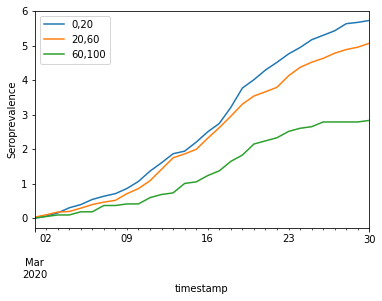

In [37]:
(100*infected_by_age/n_by_age).xs(10).cumsum().plot(label='0,20')
(100*infected_by_age/n_by_age).xs(30).cumsum().plot(label='20,60')
(100*infected_by_age/n_by_age).xs(70).cumsum().plot(label='60,100')
plt.ylabel("Seroprevalence")
plt.legend()

## Care home deaths in hospital

In [38]:
care_home_deaths_hospital = deaths_df[
    (deaths_df['location_specs'] == 'hospital') 
    & (deaths_df['residence_type'] == 'care_home')
]
care_home_deaths_hospital=care_home_deaths_hospital.groupby(
    ['name_region', 'timestamp']
).size()

In [39]:
# this may fail if your simulation doesn't have care home deaths
care_home_deaths_hospital.unstack(level=0).plot()


TypeError: no numeric data to plot

## Where people get infected as a function of time

In [ ]:
locations_df = infections_df.groupby(['location_specs', 
                                'timestamp']).size()

In [ ]:
ax = locations_df.unstack(level=0).plot()
ax.legend(loc="center left", bbox_to_anchor=(1,0.5))

In [ ]:
import matplotlib.ticker as mtick
location_counts_df = locations_df.groupby('location_specs').size()
location_counts_df = 100*location_counts_df / location_counts_df.sum()
ax = location_counts_df.sort_values().plot.bar()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.ylabel('Percentage of infections at location')
plt.xlabel('location')


## Where people of certain age get infected as a function of time

In [ ]:
old_locations_df = infections_df[
    infections_df.age > 65
].groupby(['location_specs', 'timestamp']).size()

In [ ]:
old_locations_df.unstack(level=0).plot()

## Infections in households as a function of their size.

In [ ]:
household_people = people_df[
    people_df['residence_type'] == 'household'
]

In [ ]:
household_people.loc[:,'household_size'] = household_sizes.loc[
    household_people['residence_id']
].copy(deep=True).values

In [ ]:
household_people['household_size'].hist() # in units of people

In [ ]:
household_infections_df = infections_df.merge(
    household_people['household_size'], 
    left_index=True, right_index=True, how='inner'
)

In [ ]:
(household_infections_df.groupby(
    'household_size'
).size()/household_people.groupby('household_size').size()).plot.bar()
plt.xlabel('Household size')
plt.ylabel('% of people infected by household size')
plt.xlim(0,8)

## How many households have everyone infected?

In [ ]:
n_infected_by_household = infections_df[
    infections_df['residence_type'] == 'household'
].groupby('residence_id').size()

In [ ]:
n_total_in_household = household_people[
    household_people['residence_id'].isin(
        n_infected_by_household.index
    )
].groupby('residence_id').size()

In [ ]:
(n_infected_by_household/n_total_in_household).hist()
plt.xlabel('% of the household infected')

## Percentage of infected per care home

In [ ]:
n_infected_by_carehome = infections_df[
    infections_df['residence_type'] == 'care_home'
].groupby(
    'residence_id'
).size()

In [ ]:
n_total_in_carehome = people_df[
    (people_df['residence_type'] == 'care_home') 
    & (people_df['residence_id'].isin(n_infected_by_carehome.index))  
].groupby('residence_id').size()

In [ ]:
(n_infected_by_carehome/n_total_in_carehome).hist()
plt.xlabel('% of the care home infected')

In [ ]:
# from all care homes, how many got at least one case?

In [ ]:
n_total_care_homes = people_df[
    (people_df['residence_type'] == 'care_home') 
]['residence_id'].nunique()

In [ ]:
n_total_care_homes

In [ ]:
care_homes_with_infected = infections_df[
    (infections_df['residence_type'] == 'care_home') 
]['residence_id'].nunique()

In [ ]:
care_homes_with_infected/n_total_care_homes